# Predict graphs

## Setup

In [1]:
import os
from collections import Counter
import torch
import time
import random
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from abc import ABC, abstractmethod
from typing import Set, List, Tuple
from graph_loader import load_graphs
from graph import Graph
from part import Part
from node import Node
from typing import Dict, List, Set, Tuple, Union



In [2]:
# MPS for Metal acceleration for Mac
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu") 
SEED = 0
random.seed(SEED)
# setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]  

/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_9533/966742386.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")


## Visualize

Number of graphs: 11159
Number of parts: 85140
Number of distinct parts: 1081
The smallest part_id is: 0
Number of families: 85140
Number of connected graphs: 11159
Number of cyclic graphs: 0


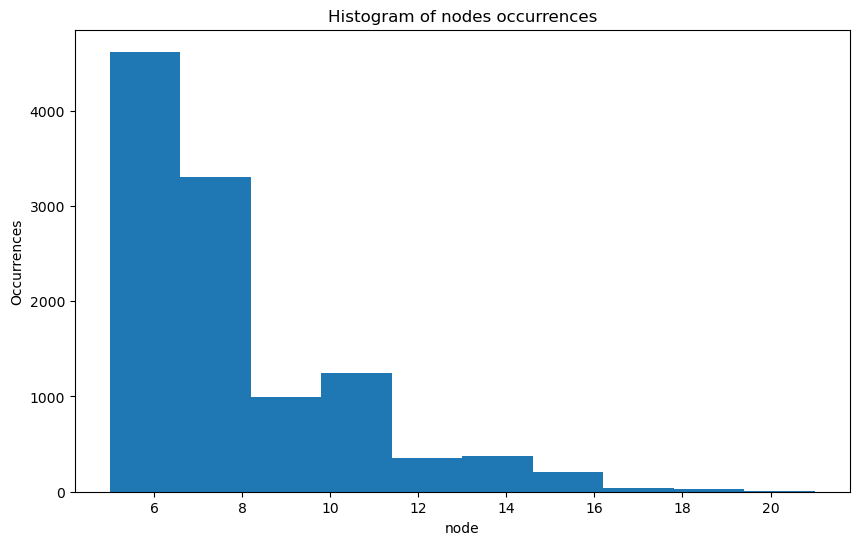

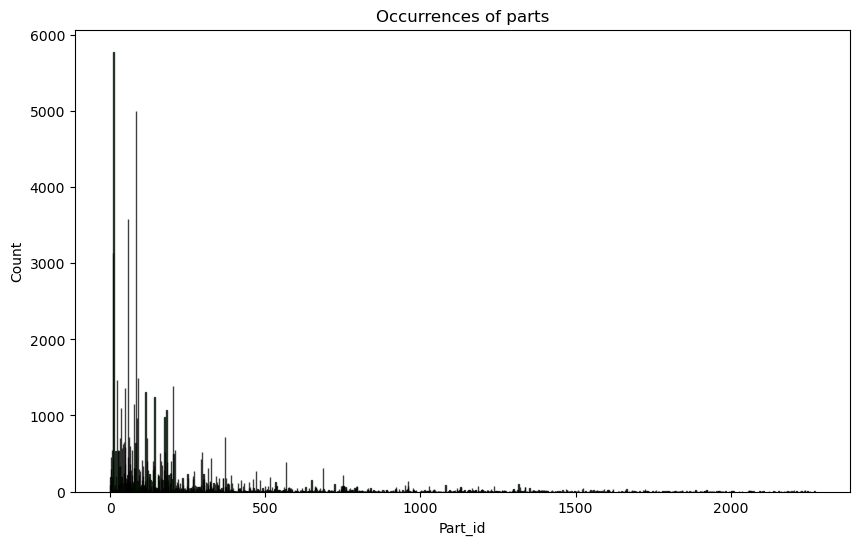

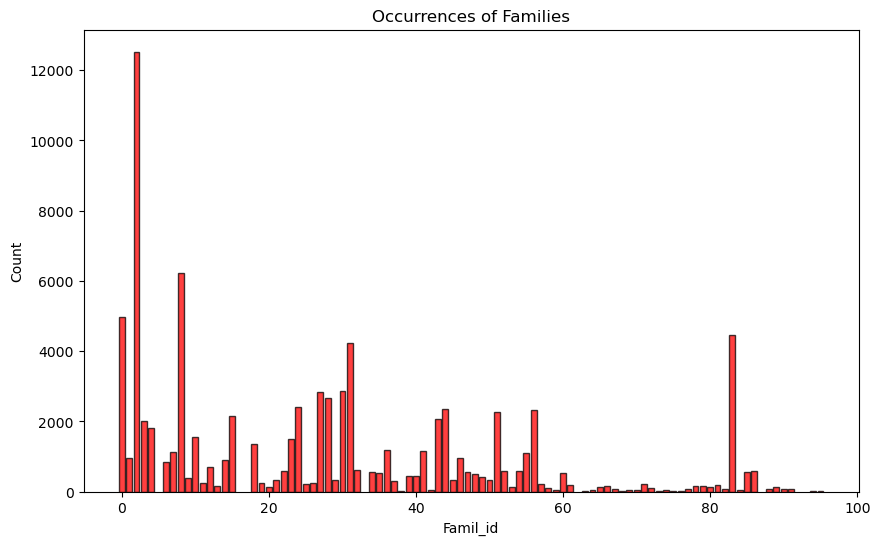

In [5]:
# descriptive analysis of the dataset
graphs = load_graphs("data/graphs.dat")
'''
graphs[0].draw()
print(graphs[0].get_parts())
print(graphs[0].get_nodes())
'''
number_of_graphs = len(graphs)
number_of_parts = 0
number_of_families = 0
number_of_connected_graphs = 0
number_of_cyclic_graphs = 0
number_of_nodes = []
part_id_counter = Counter()
family_id_counter = Counter()
node_id_counter = Counter()

part_set = set()



for graph in graphs:
    if graph.is_connected():
        number_of_connected_graphs += 1
    if graph.is_cyclic():
        number_of_cyclic_graphs += 1
    nodes = graph.get_nodes()
    parts = graph.get_parts()    
    number_of_nodes.append(len(nodes))
    for node in nodes:
        node_id_counter[node.get_id] += 1
    for part in parts:
        p_id = int(part.get_part_id())
        if int(part.get_family_id()) == 0:
            print(p_id, part.get_family_id())
        part_set.add(p_id)
        part_id_counter[p_id] += 1
        family_id_counter[int(part.get_family_id())] += 1
        number_of_parts += 1
        number_of_families += 1
    
# cannot use get_parts method because it returns a set of nodes
print(f"Number of graphs: {number_of_graphs}")
print(f"Number of parts: {number_of_parts}")
print(f"Number of distinct parts: {len(part_set)}")
# Get the smallest part_id
smallest_part_id = min(part_set)
print(f"The smallest part_id is: {smallest_part_id}")


print(f"Number of families: {number_of_families}")
print(f"Number of connected graphs: {number_of_connected_graphs}")
print(f"Number of cyclic graphs: {number_of_cyclic_graphs}")



# Convert the Counter dictionary into two lists:
part_ids, counts = zip(*part_id_counter.items())

plt.figure(figsize=(10, 6))
plt.hist(number_of_nodes)
plt.xlabel("node")
plt.ylabel("Occurrences")
plt.title("Histogram of nodes occurrences")
plt.show()


# TODO: sort the part_ids and counts
parts, counts = zip(*part_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(parts, counts, alpha=0.75, color='green', edgecolor='black')
plt.title("Occurrences of parts")
plt.xlabel("Part_id")
plt.ylabel("Count")
plt.show()

family, counts = zip(*family_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(family, counts, alpha=0.75, color='red', edgecolor='black')
plt.title("Occurrences of Families")
plt.xlabel("Famil_id")
plt.ylabel("Count")
plt.show()


## Custom Dataset
We create custom datasets for train, validation & test

In [526]:
class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")


        # Create global mapping for unique parts
        self.family_part_dict = {}


        unique_parts = set()
        for graph in self.graphs:
            parts = graph.get_parts()
            for part in parts:
                unique_parts.add(int(part.get_part_id()))
                self.family_part_dict[int(part.get_part_id())] = int(part.get_family_id())

        # unique parts and mapping across all graphs (not just within a certain split)
        unique_parts = sorted(list(unique_parts))
        self.total_global_part_to_idx = {part: idx for idx, part in enumerate(unique_parts)} # mapping part_id to index
        self.idx_to_part_id = {idx: part for part, idx in self.total_global_part_to_idx.items()}  # Reverse mapping
        self.total_num_unique_parts = len(unique_parts)

        # Split: 70% training, 15% validation, 15% test
        train_graphs, test_graphs = train_test_split(self.graphs, test_size=0.3, random_state=seed)
        validation_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=seed)

        if train:
            self.graphs = train_graphs
        elif validation:
            self.graphs = validation_graphs
        elif test:
            self.graphs = test_graphs

        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Retrieves the parts and graph for the given index.
        :param idx: Index of the graph.
        :return: Tuple of (parts, graph).
        """
        graph = self.graphs[idx]
        
        # Initialize a count vector for parts
        part_frequency_vector = np.zeros(self.total_num_unique_parts, dtype=np.int32)

        # Count occurrences of each part
        parts = graph.get_parts()
        for part in parts:
            part_id = int(part.get_part_id())
            mapped_id = self.total_global_part_to_idx[part_id]
            part_frequency_vector[mapped_id] += 1  # Increment the count
        
        # Ensure part_features is 2D
        part_frequency_vector = torch.tensor(part_frequency_vector, dtype=torch.float).unsqueeze(-1)

        return part_frequency_vector, graph


    ''' ---> geht nicht!!!!!
    def __getitem__(self, idx):
        """
        Retrieves the parts and graph for the given index.
        :param idx: Index of the graph.
        :return: Tuple of (parts, graph).
        """
        graph = self.graphs[idx]

        # one-hot encode the parts
        # vector with length equal to the number of unique parts
        one_hot_encoding_parts = np.zeros(self.total_num_unique_parts)

        parts = graph.get_parts()
        for part in parts:
            part_id = int(part.get_part_id())
            one_hot_encoding_parts[self.total_global_part_to_idx[part_id]] = 1
        
        return one_hot_encoding_parts, graph
    '''


    def graph_to_local_adjacency_matrix(self, graph):
        """
        Converts a graph to a local adjacency matrix.
        """
        parts = graph.get_parts()
        part_order = tuple(sorted(parts, key=lambda part: part.get_part_id()))
        adj_matrix = graph.get_adjacency_matrix(part_order)

        return adj_matrix
        

        
    #TODO: implement with global mapping
    def graph_to_global_adjacency_matrix(self, graph):
        """
        Converts a graph to a global adjacency matrix with a global part-to-index mapping.
        """
        # Determine the maximum part_id to size the adjacency matrix
        adj_matrix = np.zeros((self.total_num_unique_parts, self.total_num_unique_parts), dtype=int)

        edges: Dict[Node, List[Node]] = graph.get_edges()


        for node, connected_nodes in edges.items():
            part_id = int(node.get_part().get_part_id()) # cast str to int
            mapped_part_idx = self.total_global_part_to_idx[part_id]

            for connected_node in connected_nodes:
                connected_part_id = int(connected_node.get_part().get_part_id())
                mapped_connected_part_idx = self.total_global_part_to_idx[connected_part_id]

                # Update the adjacency matrix symmetrically
                adj_matrix[mapped_part_idx, mapped_connected_part_idx] = 1
                adj_matrix[mapped_connected_part_idx, mapped_part_idx] = 1

        return adj_matrix


    def graph_to_edge_list(self, graph):
        """
        Converts a graph to an edge list representation.
        Each edge is represented as a tuple (part_id, connected_part_id).
        """
        edge_list = []

        edges: Dict[Node, List[Node]] = graph.get_edges()

        for node, connected_nodes in edges.items():
            part_id = int(node.get_part().get_part_id())  # Ensure part_id is int
            mapped_part_idx = self.total_global_part_to_idx[part_id]


            for connected_node in connected_nodes:
                connected_part_id = int(connected_node.get_part().get_part_id())  # Ensure connected_part_id is int
                mapped_connected_part_idx = self.total_global_part_to_idx[connected_part_id]


                # Add the edge as a tuple (part_id, connected_part_id)
                # the same edge can occure more than once in the edge list because it can occur more than once in a graph
                edge_list.append((mapped_part_idx, mapped_connected_part_idx))
                edge_list.append((mapped_connected_part_idx, mapped_part_idx)) # --> for symmetry


        return edge_list


In [527]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

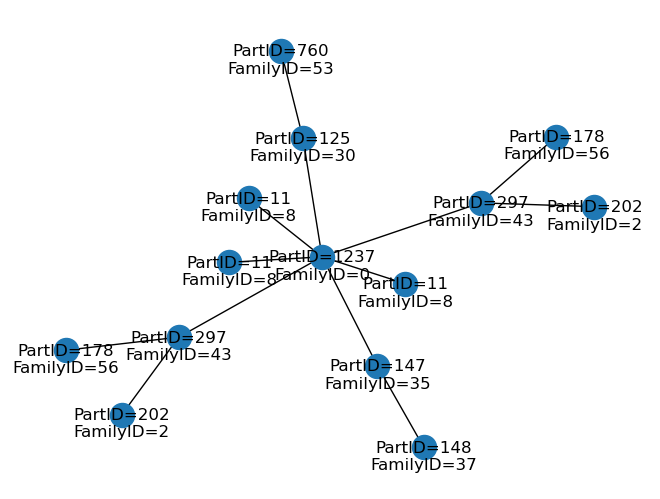

In [533]:
training_set[1][0][:100]
training_set[1][1].draw()

In [514]:
import torch
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output: edge existence probability
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [516]:
def prepare_ffn_data(graph_dataset):
    edge_features = []
    edge_labels = []

    for one_hot_parts, graph in graph_dataset:
        # Node features
        node_features = torch.tensor(one_hot_parts, dtype=torch.float)

        # Edge list and adjacency matrix
        edge_list = graph_dataset.graph_to_edge_list(graph)
        adj_matrix = graph_dataset.graph_to_global_adjacency_matrix(graph)

        # Create edge features and labels
        for (src, dest) in edge_list:
            # Feature: Concatenate node features
            edge_feature = torch.cat([node_features[src], node_features[dest]])
            edge_features.append(edge_feature)

            # Label: Adjacency matrix entry
            edge_labels.append(adj_matrix[src, dest])

    edge_features = torch.stack(edge_features)
    edge_labels = torch.tensor(edge_labels, dtype=torch.float)
    return edge_features, edge_labels


In [518]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
train_features, train_labels = prepare_ffn_data(training_set)
val_features, val_labels = prepare_ffn_data(validation_set)

# Define the model, loss, and optimizer
input_dim = train_features.size(1)
model = FeedForwardNet(input_dim=input_dim, hidden_dim=128).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()

    # Forward pass
    optimizer.zero_grad()
    predictions = model(train_features.to(device)).squeeze()
    loss = criterion(predictions, train_labels.to(device))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_36625/3853209759.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(one_hot_parts, dtype=torch.float)


Epoch 1/200, Loss: 0.6167
Epoch 2/200, Loss: 0.5567
Epoch 3/200, Loss: 0.5020
Epoch 4/200, Loss: 0.4522
Epoch 5/200, Loss: 0.4071
Epoch 6/200, Loss: 0.3662
Epoch 7/200, Loss: 0.3286
Epoch 8/200, Loss: 0.2941
Epoch 9/200, Loss: 0.2625
Epoch 10/200, Loss: 0.2335
Epoch 11/200, Loss: 0.2069
Epoch 12/200, Loss: 0.1828
Epoch 13/200, Loss: 0.1608
Epoch 14/200, Loss: 0.1412
Epoch 15/200, Loss: 0.1238
Epoch 16/200, Loss: 0.1085
Epoch 17/200, Loss: 0.0949
Epoch 18/200, Loss: 0.0829
Epoch 19/200, Loss: 0.0724
Epoch 20/200, Loss: 0.0632
Epoch 21/200, Loss: 0.0553
Epoch 22/200, Loss: 0.0484
Epoch 23/200, Loss: 0.0424
Epoch 24/200, Loss: 0.0373
Epoch 25/200, Loss: 0.0328
Epoch 26/200, Loss: 0.0290
Epoch 27/200, Loss: 0.0257
Epoch 28/200, Loss: 0.0228
Epoch 29/200, Loss: 0.0203
Epoch 30/200, Loss: 0.0182
Epoch 31/200, Loss: 0.0164
Epoch 32/200, Loss: 0.0147
Epoch 33/200, Loss: 0.0133
Epoch 34/200, Loss: 0.0121
Epoch 35/200, Loss: 0.0110
Epoch 36/200, Loss: 0.0101
Epoch 37/200, Loss: 0.0093
Epoch 38/2

In [519]:
train_features, train_labels = prepare_ffn_data(training_set)
print(f"Train Features Shape: {train_features.shape}")  # Should be (num_edges, 2 * feature_dim)
print(f"Train Labels Shape: {train_labels.shape}")      # Should be (num_edges,)


/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_36625/3853209759.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(one_hot_parts, dtype=torch.float)


Train Features Shape: torch.Size([206664, 2])
Train Labels Shape: torch.Size([206664])


In [520]:
import torch
from evaluation import MyPredictionModel

class FFNPredictionModel(MyPredictionModel):
    def __init__(self, model, global_mapping, device):
        """
        Initialize the prediction model.
        :param model: Trained PyTorch model.
        :param global_mapping: Mapping from part IDs to indices.
        :param device: Device for running the model (CPU/GPU).
        """
        self.model = model
        self.global_mapping = global_mapping
        self.device = device

    def predict_graph(self, parts: Set[Part]) -> Graph:
        """
        Predicts a graph based on the given parts.
        :param parts: Set of parts for the graph.
        :return: Predicted Graph object.
        """
        # Convert parts to one-hot encoded features
        num_parts = len(self.global_mapping)
        one_hot_encoding = torch.zeros((len(parts), num_parts), device=self.device)
        
        part_ids = [int(part.get_part_id()) for part in parts]
        for i, part_id in enumerate(part_ids):
            part_idx = self.global_mapping[part_id]
            one_hot_encoding[i, part_idx] = 1
        
        # Generate edge features for all possible pairs
        edge_features = []
        for i in range(len(parts)):
            for j in range(len(parts)):
                edge_features.append(torch.cat([one_hot_encoding[i], one_hot_encoding[j]]))
        
        edge_features = torch.stack(edge_features).to(self.device)

        # Predict edge probabilities
        with torch.no_grad():
            edge_probs = self.model(edge_features).squeeze()

        # Create adjacency matrix
        adj_matrix = (edge_probs > 0.5).float().reshape(len(parts), len(parts))

        # Create a Graph object from adjacency matrix
        predicted_graph = Graph()
        for i, part in enumerate(parts):
            predicted_graph.add_node(part)
        
        for i in range(len(parts)):
            for j in range(len(parts)):
                if adj_matrix[i, j] > 0:
                    predicted_graph.add_edge(part_ids[i], part_ids[j])

        return predicted_graph


In [521]:
torch.save(model.state_dict(), "trained_ffn_model.pth")


In [522]:
model = FeedForwardNet(input_dim=train_features.size(1), hidden_dim=128)
model.load_state_dict(torch.load("trained_ffn_model.pth"))
model.eval()


/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_36625/4016308903.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_ffn

FeedForwardNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

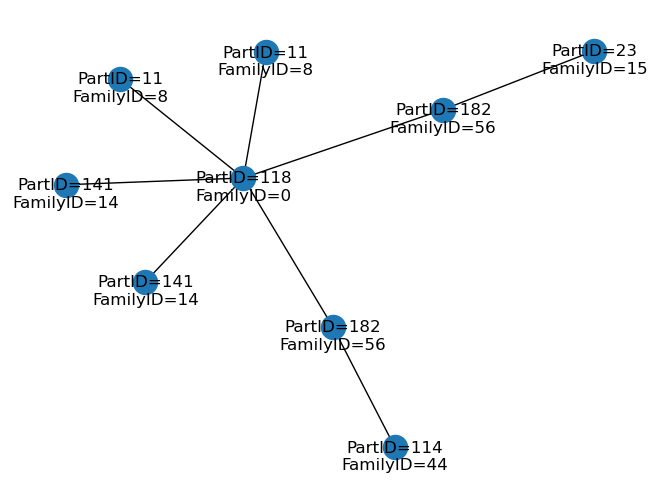

part_id: 11 - count 2
ÖLDJFKLÖJDFÖLKFJ
part_id: 11 - family id: 8
ÖLDJFKLÖJDFÖLKFJ
part_id: 11 - family id: 8
part_id: 23 - count 1
ÖLDJFKLÖJDFÖLKFJ
part_id: 23 - family id: 15
part_id: 114 - count 1
ÖLDJFKLÖJDFÖLKFJ
part_id: 114 - family id: 44
part_id: 118 - count 1
ÖLDJFKLÖJDFÖLKFJ
part_id: 118 - family id: 0


AssertionError: Creation of Part failed. Fields `part_id` and `family_id` must not be empty.

In [538]:
test_data = []
for parts, graph in testing_set:
    # Remap parts tensor to set of Part objects
    parts_set = set()
    non_zero_indices = torch.nonzero(parts.squeeze(), as_tuple=True)[0]  # Find indices with non-zero values

    graph.draw()
    for idx in non_zero_indices:
        part_id = training_set.idx_to_part_id[int(idx)]  # Remap index to part_id
        count = int(parts[idx])  # Get the count of this part

        print(f"part_id: {part_id} - count {count}")
        # Add the part `count` times
        for _ in range(count):
            family_id = training_set.family_part_dict[part_id]
            print("ÖLDJFKLÖJDFÖLKFJ")
            print(f"part_id: {part_id} - family id: {family_id}")
            parts_set.add(Part(part_id, family_id))  # Replace `Part(part_id)` with the actual Part constructor

    # Append the remapped (parts_set, graph) pair
    test_data.append((parts_set, graph))



'''
    parts_set = set()
    non_zero_indices = torch.nonzero(parts.squeeze(), as_tuple=True)[0]  # Find indices with non-zero values



    part_ids = torch.nonzero(part_features, as_tuple=True)[1].tolist()  # Get indices where value is 1
    parts = {Part(part_id) for part_id in part_ids}  # Create Part objects
    
    # Append (parts, graph) tuple
    test_data.append((parts, graph))
'''


In [477]:
test_data = []
for parts, graph in testing_set:
    # remap the part_ids to the global mapping

    print(parts[:100])

    part_set = {Part(part.get_part_id(), part.get_family_id()) for part in parts}
    test_data.append((part_set, graph))



tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

AttributeError: 'Tensor' object has no attribute 'get_part_id'

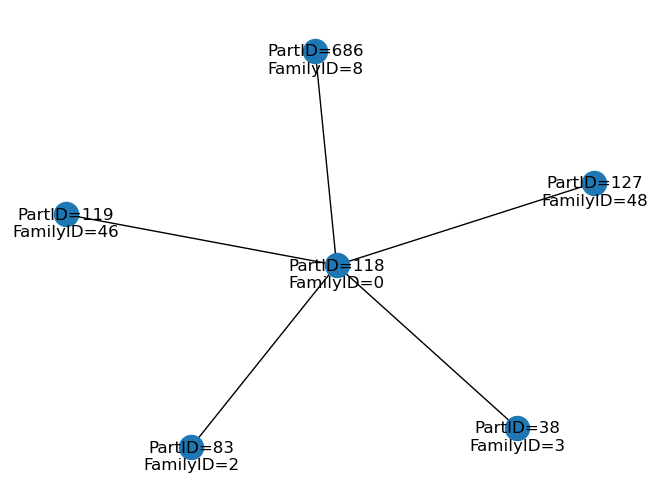

[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[0 1 1 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
0
0
[(107, 108), (108, 107), (107, 114), (114, 107), (107, 34), (34, 107), (107, 518), (518, 107), (107, 76), (76, 107), (114, 107), (107, 114), (108, 107), (107, 108), (34, 107), (107, 34), (76, 107), (107, 76), (518, 107), (107, 518)]


In [394]:
training_set[0][1].draw()
part_order = tuple(sorted(training_set[0][1].get_parts(), key=lambda part: part.get_part_id()))
print(Graph.get_adjacency_matrix(training_set[0][1], part_order))
print(training_set.graph_to_local_adjacency_matrix(training_set[0][1]))
print(training_set.graph_to_global_adjacency_matrix(training_set[0][1])[83][117])
print(training_set.graph_to_global_adjacency_matrix(training_set[0][1])[118][83])
print(training_set.graph_to_edge_list(training_set[0][1]))



In [369]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GraphGenerator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(GraphGenerator, self).__init__()
        self.gcn1 = GCNConv(embedding_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # Output: edge existence (0 or 1)
    
    def forward(self, node_features, edge_index):
        # Perform GCN layers
        x = self.gcn1(node_features, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)

        # Predict edge probabilities
        edge_logits = self.fc(x)
        edge_probs = torch.sigmoid(edge_logits)
        return edge_probs


In [370]:
from torch_geometric.data import Data

def graph_to_data(graph_dataset):
    data_list = []

    for one_hot_parts, graph in graph_dataset:
        # Node features
        node_features = torch.tensor(one_hot_parts, dtype=torch.float)

        # Edge indices
        edge_list = graph_dataset.graph_to_edge_list(graph)
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # Transpose to COO format

        # Target adjacency matrix
        adj_matrix = graph_dataset.graph_to_global_adjacency_matrix(graph)
        edge_labels = adj_matrix[edge_index[0], edge_index[1]]

        # Create a PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_labels)
        data_list.append(data)

    return data_list

train_data_list = graph_to_data(training_set)
val_data_list = graph_to_data(validation_set)
test_data_list = graph_to_data(testing_set)


In [371]:
from torch_geometric.loader import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)


In [373]:
import torch.nn as nn
import torch.optim as optim

# Define the model
model = GraphGenerator(
    embedding_dim=training_set.total_num_unique_parts,  # Number of unique parts
    hidden_dim=128  # Hidden dimension for GCN layers
).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for edge existence
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate of 0.001


In [374]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0

    for data in loader:
        data = data.to(device)  # Move batch to device (CPU or GPU)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        pred_edge_probs = model(data.x, data.edge_index).squeeze()  # Predict edge probabilities
        loss = criterion(pred_edge_probs, data.edge_attr.float())  # Compute the loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss for reporting

    return total_loss / len(loader)  # Average loss for the epoch


In [375]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def validate(model, loader, device):
    model.eval()  # Set the model to evaluation mode
    total_preds = []
    total_targets = []

    with torch.no_grad():  # Disable gradient computation
        for data in loader:
            data = data.to(device)

            # Forward pass
            pred_edge_probs = model(data.x, data.edge_index).squeeze()
            pred_edge_labels = (pred_edge_probs > 0.5).float()  # Threshold to get binary predictions

            total_preds.extend(pred_edge_labels.cpu().numpy())
            total_targets.extend(data.edge_attr.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(total_targets, total_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        total_targets, total_preds, average='binary'
    )
    return accuracy, precision, recall, f1


In [380]:
for a, b in train_loader:
    print(a)
    print


ValueError: too many values to unpack (expected 2)

In [376]:
epochs = 50  # Number of epochs
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)  # Train for one epoch
    val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, device)  # Validate on the validation set

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

## Random Graph
This creates a random graph based on a given parts. This is possible because there is only a limited number of graphs possible since no cycles are allowed.
The random graph serves as a baseline for future models.

In [193]:
from evaluation import edge_accuracy

edge_accuracies = []

# only use the test set because no training is required since the model builds a valid but random graph
for graph in testing_set:
    nodes = graph.get_nodes()
    # create a random graph
    random_graph = Graph()

    # list of nodes in a random order
    random_nodes = list(nodes)
    # how to shuffle randomly basedn on SEED
    random.seed(SEED)
    random.shuffle(random_nodes)

    # add the nodes (from random_nodes) to the random graph so that no cycle is created
    for node in random_nodes:
        # take a random node from the random graph
        ## cannot choose from an empty sequence at the beginning when the random graph is empty
        if len(random_graph.get_nodes()) == 0:
            random_graph.__add_node(node)
            continue
        random_node = random.choice(random_graph.get_nodes())

        # add the node to the random graph by connecting it to the random node with add_undirected_edge
        random_graph.add_undirected_edge(random_node, node)



print(nodes)
print(random_nodes)
print(random_graph.get_nodes())



AttributeError: 'tuple' object has no attribute 'get_nodes'

In [3]:
# RandomForestPredictionModel Implementation

import numpy as np
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from typing import List, Set, Tuple
from evaluation import MyPredictionModel
from graph import Graph
from part import Part

class RandomForestPredictionModel(MyPredictionModel):
    def __init__(self):
        """Initialize the Random Forest model."""
        self.model = RandomForestClassifier()

    def _graph_to_features(self, graph: Graph):
        """Convert a Graph to a feature matrix and labels."""
        nx_graph = graph.to_nx()
        nodes = list(nx_graph.nodes(data=True))
        edges = list(nx_graph.edges(data=False))

        # Extract features directly from Node and Part objects
        node_features = np.array([
            [n[0].get_part().get_part_id(), n[0].get_part().get_family_id()]  # n[0] is the Node object
            for n in nodes
        ])
        edge_indices = np.array([
            [nodes.index((u, nx_graph.nodes[u])), nodes.index((v, nx_graph.nodes[v]))]
            for u, v in edges
        ])

        return node_features, edge_indices

    def fit(self, training_data: List[Tuple[Set[Part], Graph]]):
        """Train the Random Forest model using edge-based features."""
        features = []
        labels = []

        for parts, graph in training_data:
            node_features, edge_indices = self._graph_to_features(graph)

            # Generate edge-based features
            for edge in edge_indices:
                # Features for edge: concatenate node features
                edge_feature = np.hstack([node_features[edge[0]], node_features[edge[1]]])
                features.append(edge_feature)
                labels.append(1)  # Label 1 for existing edges

            # Optionally add negative samples (non-existent edges) for training
            num_nodes = len(node_features)
            existing_edges = set(map(tuple, edge_indices))
            for _ in range(len(edge_indices)):  # Add equal number of negative samples
                i, j = np.random.choice(num_nodes, size=2, replace=False)
                if (i, j) not in existing_edges and (j, i) not in existing_edges:
                    edge_feature = np.hstack([node_features[i], node_features[j]])
                    features.append(edge_feature)
                    labels.append(0)  # Label 0 for non-existent edges

        X = np.array(features)
        y = np.array(labels)

        self.model.fit(X, y)


    def predict_graph(self, parts: Set[Part]) -> Graph:
        """Predict a Graph connecting the given parts."""
        graph = Graph()

        # Add nodes for all parts
        for part in parts:
            _ = graph._Graph__get_node_for_part(part)  # Create nodes

        # Add edges between parts based on model predictions
        part_list = list(parts)
        features = []

        # Generate features for all possible edges
        for i in range(len(part_list)):
            for j in range(i + 1, len(part_list)):
                part1 = part_list[i]
                part2 = part_list[j]
                feature = [part1.get_part_id(), part1.get_family_id(),
                        part2.get_part_id(), part2.get_family_id()]
                features.append(feature)

        # Predict which edges should exist
        predictions = self.model.predict(features)

        # Add edges to the graph for positive predictions
        for (i, j), prediction in zip([(i, j) for i in range(len(part_list)) for j in range(i + 1, len(part_list))], predictions):
            if prediction == 1:
                graph.add_undirected_edge(part_list[i], part_list[j])

        return graph


ModuleNotFoundError: No module named 'networkx'

[(Node(NodeID=3, Part=Part(PartID=61, FamilyID=6)), {'info': '\nPartID=61\nFamilyID=6', 'nx_has_info': 'nb=61, nn=6'}), (Node(NodeID=4, Part=Part(PartID=58, FamilyID=31)), {'info': '\nPartID=58\nFamilyID=31', 'nx_has_info': 'nb=58, nn=31'}), (Node(NodeID=2, Part=Part(PartID=25, FamilyID=83)), {'info': '\nPartID=25\nFamilyID=83', 'nx_has_info': 'nb=25, nn=83'}), (Node(NodeID=0, Part=Part(PartID=587, FamilyID=4)), {'info': '\nPartID=587\nFamilyID=4', 'nx_has_info': 'nb=587, nn=4'}), (Node(NodeID=1, Part=Part(PartID=27, FamilyID=18)), {'info': '\nPartID=27\nFamilyID=18', 'nx_has_info': 'nb=27, nn=18'}), (Node(NodeID=5, Part=Part(PartID=11, FamilyID=8)), {'info': '\nPartID=11\nFamilyID=8', 'nx_has_info': 'nb=11, nn=8'}), (Node(NodeID=6, Part=Part(PartID=58, FamilyID=31)), {'info': '\nPartID=58\nFamilyID=31', 'nx_has_info': 'nb=58, nn=31'})]


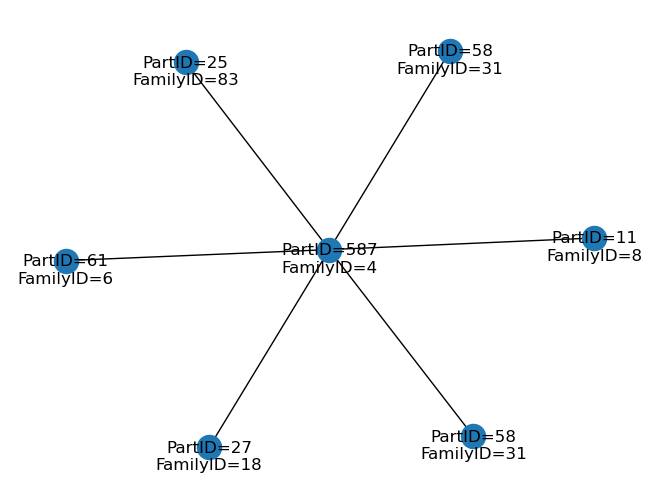

In [10]:
from graph_loader import load_graphs
from node import Node
from graph import Graph

# Load graphs from the dataset
graphs = load_graphs("data/graphs.dat")

# Prepare training data
training_data = []
for graph in graphs:
    parts = {node.get_part() for node in graph.get_nodes()}
    training_data.append((parts, graph))

nx_graph = graph.to_nx()
print(list(nx_graph.nodes(data=True)))
graph.draw()



In [11]:
# Initialize the model
model = RandomForestPredictionModel()

# Train the model
model.fit(training_data)


Graph has 0 nodes and 0 edges


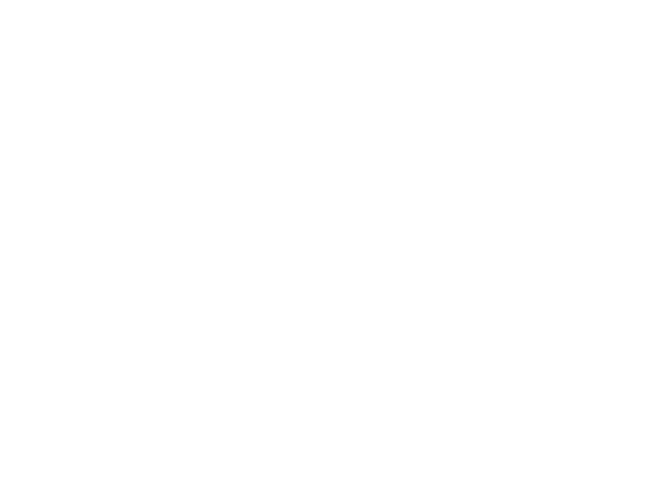

In [15]:
# Test parts
test_parts = {Part(part_id=1, family_id=10), Part(part_id=2, family_id=20), Part(part_id=3, family_id=30)}

# Predict the graph
predicted_graph = model.predict_graph(test_parts)

# Check the graph details
print(f"Graph has {len(predicted_graph.get_nodes())} nodes and {len(predicted_graph.get_edges())} edges")

# Optional: Visualize the graph
predicted_graph.draw()




In [16]:
from evaluation import evaluate

# Test data
test_data = training_data  # Replace with actual holdout test data

# Evaluate the model
score = evaluate(model, test_data)
print(f"Model evaluation score: {score}")


AssertionError: Mismatch in number of nodes.

In [14]:
import pickle
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

def process_graph(graph):
    network_graph = graph.to_nx()
    
    # Convert to PyTorch Geometric Data
    data = from_networkx(graph)
    data.x = torch.tensor(
        [node["feature"] for _, node in graph.nodes(data=True)],
        dtype=torch.float
    )
    return data

In [30]:
# Load and process all graphs
file_path = "data/graphs.dat"
raw_graphs = load_graphs(file_path)
processed_graphs = [process_graph(g) for g in raw_graphs]
len(processed_graphs), len(raw_graphs)


AttributeError: 'Graph' object has no attribute 'is_directed'

In [31]:
for graph in processed_graphs:
    for node in graph.nodes:
        if "feature" not in graph.nodes[node]:
            graph.nodes[node]["feature"] = [1.0]  # Default feature


In [32]:
from torch_geometric.utils import from_networkx

pyg_graphs = []
for graph in processed_graphs:
    # Convert NetworkX graph to PyTorch Geometric Data
    data = from_networkx(graph)
    
    # Ensure node features are in the correct format
    data.x = torch.tensor(
        [graph.nodes[node]["feature"] for node in graph.nodes()],
        dtype=torch.float
    )
    
    pyg_graphs.append(data)

print(f"Converted {len(pyg_graphs)} graphs to PyTorch Geometric format.")


Converted 11159 graphs to PyTorch Geometric format.


In [33]:
from torch_geometric.loader import DataLoader

# Create a DataLoader for batching
batch_size = 32
train_loader = DataLoader(pyg_graphs, batch_size=batch_size, shuffle=True)



In [35]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Define a GNN Model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize Model, Optimizer, and Loss
input_dim = pyg_graphs[0].x.shape[1]  # Feature dimension
hidden_dim = 64
output_dim = 16  # Example output size (embedding dimension)

model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Use an appropriate loss for your task

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        out = model(batch.x, batch.edge_index)

        # Compute loss (example: reconstruction loss)
        labels = torch.rand(out.size())  # Placeholder target (use your task-specific labels)
        loss = criterion(out, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/50, Loss: 40.5852
Epoch 2/50, Loss: 31.2778
Epoch 3/50, Loss: 30.5418
Epoch 4/50, Loss: 29.9832
Epoch 5/50, Loss: 29.6069
Epoch 6/50, Loss: 29.3582
Epoch 7/50, Loss: 29.3428
Epoch 8/50, Loss: 29.2518
Epoch 9/50, Loss: 29.1819
Epoch 10/50, Loss: 29.1644
Epoch 11/50, Loss: 29.1729
Epoch 12/50, Loss: 29.0797
Epoch 13/50, Loss: 29.0658
Epoch 14/50, Loss: 29.0924
Epoch 15/50, Loss: 29.0977
Epoch 16/50, Loss: 29.1105
Epoch 17/50, Loss: 29.1003
Epoch 18/50, Loss: 29.0843
Epoch 19/50, Loss: 29.1113
Epoch 20/50, Loss: 29.1185
Epoch 21/50, Loss: 29.1192
Epoch 22/50, Loss: 29.1097
Epoch 23/50, Loss: 29.0794
Epoch 24/50, Loss: 29.1140
Epoch 25/50, Loss: 29.0440
Epoch 26/50, Loss: 29.0654
Epoch 27/50, Loss: 29.1112
Epoch 28/50, Loss: 29.0715
Epoch 29/50, Loss: 29.0801
Epoch 30/50, Loss: 29.0928
Epoch 31/50, Loss: 29.0973
Epoch 32/50, Loss: 29.1477
Epoch 33/50, Loss: 29.0701
Epoch 34/50, Loss: 29.0567
Epoch 35/50, Loss: 29.1030
Epoch 36/50, Loss: 29.1076
Epoch 37/50, Loss: 29.1050
Epoch 38/5

In [37]:
class MyGNNModel(MyPredictionModel):
    def __init__(self, trained_model):
        self.model = trained_model

    def predict_graph(self, parts: Set[Part]) -> Graph:
        # Step 1: Encode parts into node features
        encoded_parts = self._encode_parts(parts)
        
        # Step 2: Predict edges
        with torch.no_grad():
            embeddings = self.model(encoded_parts.x, encoded_parts.edge_index)
            edge_probs = torch.matmul(embeddings, embeddings.T)
            adjacency_matrix = (edge_probs > 0.5).float()  # Example threshold
        
        # Step 3: Construct graph
        return self._construct_graph(adjacency_matrix, parts)

    def _encode_parts(self, parts):
        # Convert parts to PyTorch Geometric Data object
        pass  # Implement part-to-feature encoding logic

    def _construct_graph(self, adjacency_matrix, parts):
        # Create a graph using adjacency matrix and parts
        pass  # Implement graph construction logic


NameError: name 'MyPredictionModel' is not defined